# Notebook 3 - Identifiability

In this notebook we compare two different branching pathways with 4 genes, from both ‘single-cell’ and ‘bulk’ viewpoints.

In [1]:
import numpy as np
import sys; sys.path += ['../']
from harissa import NetworkModel
from pathlib import Path
data_path1 = Path(f'pathways_data1.txt')
data_path2 = Path(f'pathways_data2.txt')

## Networks

In [2]:
# Model 1
model1 = NetworkModel(4)
model1.d[0] = 1
model1.d[1] = 0.2
model1.basal[1:] = -5
model1.inter[0,1] = 10
model1.inter[1,2] = 10
model1.inter[1,3] = 10
model1.inter[2,4] = 10
# Model 2
model2 = NetworkModel(4)
model2.d[0] = 1
model2.d[1] = 0.2
model2.basal[1:] = -5
model2.inter[0,1] = 10
model2.inter[1,2] = 10
model2.inter[1,3] = 10
model2.inter[3,4] = 10

This time we set the node positions manually to better compare the two networks.

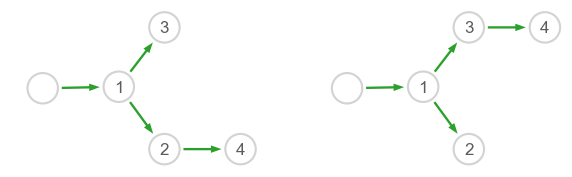

In [3]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from harissa.utils import build_pos, plot_network
fig = plt.figure(figsize=(10,3))
gs = gridspec.GridSpec(1,2)
# Number of genes including stimulus
G = model1.basal.size
# Node labels and positions
names = [''] + [f'{i+1}' for i in range(4)]
pos1 = np.array([[-0.6,0],[-0.1,0.01],[0.2,-0.4],[0.2,0.4],[0.7,-0.4]])
pos2 = np.array([[-0.6,0],[-0.1,0.01],[0.2,-0.4],[0.2,0.4],[0.7, 0.4]])
# Draw the networks
ax = plt.subplot(gs[0,0])
plot_network(model1.inter, pos1, axes=fig.gca(), names=names, scale=6)
ax = plt.subplot(gs[0,1])
plot_network(model2.inter, pos2, axes=fig.gca(), names=names, scale=6)

## Datasets

Here we use Numba for simulations: this option takes some time to compile (~8s) but is much more efficient afterwards, so it is well suited for large numbers of genes and/or cells.

In [4]:
# Number of cells
C = 10000
# Set the time points
k = np.linspace(0, C, 11, dtype='int')
t = np.linspace(0, 9, 10, dtype='int')
print('Time points: ' + ', '.join([f'{ti}' for ti in t]))
print(f'{int(C/t.size)} cells per time point (total {C} cells)')
time = np.zeros(C, dtype='int')
for i in range(10):
    time[k[i]:k[i+1]] = t[i]
# Prepare data
data1 = np.zeros((C,G), dtype='int')
data1[:,0] = time # Time points
data2 = data1.copy()
# Generate data
for k in range(C):
    # Data for model 1
    sim1 = model1.simulate(time[k], burnin=5, use_numba=True)
    data1[k,1:] = np.random.poisson(sim1.m[0])
    # Data for model 2
    sim2 = model2.simulate(time[k], burnin=5, use_numba=True)
    data2[k,1:] = np.random.poisson(sim2.m[0])
# Save data in basic format
np.savetxt('pathways_data1.txt', data1, fmt='%d', delimiter='\t')
np.savetxt('pathways_data2.txt', data2, fmt='%d', delimiter='\t')

Time points: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9
1000 cells per time point (total 10000 cells)


## Population-average trajectories

Looking at network structures, it is clear that population-average trajectories, i.e., bulk data, does not contain enough information to recover all interactions: if $d_{0,2}=d_{0,3}$ and $d_{1,2}=d_{1,3}$, one *cannot distinguish* between edges 2 → 4 and 3 → 4 as genes 2 and 3 have the same average dynamics.

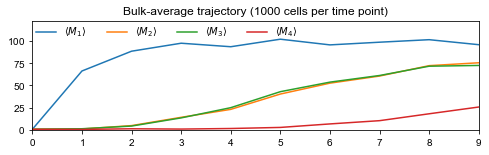

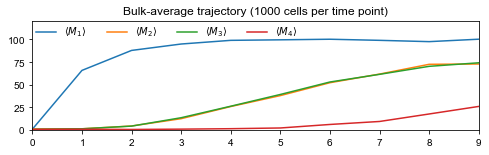

In [5]:
for i, data in [(1,data1),(2,data2)]:
    # Import time points
    time = np.sort(list(set(data[:,0])))
    T = np.size(time)
    # Average for each time point
    traj = np.zeros((T,G-1))
    for k, t in enumerate(time):
        traj[k] = np.mean(data[data[:,0]==t,1:], axis=0)
    # Draw trajectory and export figure
    fig = plt.figure(figsize=(8,2))
    labels = [rf'$\langle M_{i} \rangle$' for i in range(1,G)]
    plt.plot(time, traj, label=labels)
    ax = plt.gca()
    ax.set_xlim(time[0], time[-1])
    ax.set_ylim(0, 1.2*np.max(traj))
    ax.set_xticks(time)
    ax.set_title(f'Bulk-average trajectory ({int(C/T)} cells per time point)')
    ax.legend(loc='upper left', ncol=G, borderaxespad=0, frameon=False)

## Inference from single-cell data

Here, since we know the number of edges we are looking for, we choose to keep only the strongest 4 edges instead of applying a cutoff to the weights.

In [6]:
inter = {}
for k in [1,2]:
    # Load the data
    data = np.loadtxt(f'pathways_data{k}.txt', dtype=int, delimiter='\t')
    # Calibrate the model
    model = NetworkModel()
    model.fit(data)
    # Keep the strongest four edges
    inter[k] = np.zeros((G,G))
    a = np.abs(model.inter)
    a -= np.diag(np.diag(a))
    for n in range(4):
        (i,j) = np.unravel_index(np.argmax(a, axis=None), a.shape)
        inter[k][i,j] = model.inter[i,j]
        a[i,j] = 0
    print(f'inter[{k}] = {inter[k]}')

inter[1] = [[0.         3.29436519 0.         0.         0.        ]
 [0.         0.         1.76090955 1.59615292 0.        ]
 [0.         0.         0.         0.         0.59599403]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]]
inter[2] = [[0.         3.31286944 0.         0.         0.        ]
 [0.         0.         1.56295074 1.76685173 0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.51416432]
 [0.         0.         0.         0.         0.        ]]


## Drawing inferred networks

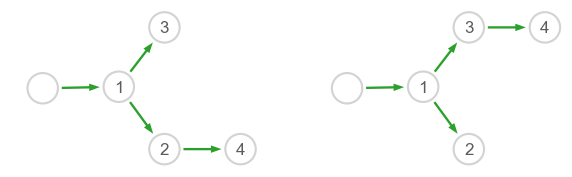

In [7]:
fig = plt.figure(figsize=(10,3))
gs = gridspec.GridSpec(1,2)
# Draw the networks
ax = plt.subplot(gs[0,0])
plot_network(inter[1], pos1, axes=fig.gca(), names=names, scale=6)
ax = plt.subplot(gs[0,1])
plot_network(inter[2], pos2, axes=fig.gca(), names=names, scale=6)

The result might not be always perfect, but the edges 2 → 4 and 3 → 4 should generally be inferred correctly.